# Text Classification using SciKit Learn

We will use the cleaned version of the covid tweets `TweetC_train.csv` and `TweetC_test.csv` to fit and test classic Machine Learning models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
train_data = pd.read_csv('Data/TweetC_train.csv')
test_data = pd.read_csv('Data/TweetC_test.csv')
print(f'Training obs: {train_data.shape[0]}, and testing obs: {test_data.shape[0]}')

Training obs: 41160, and testing obs: 3798


In [3]:
train_data.head()

,Tweet,Sentiment_encoded
0,advice talk to your neighbours family to excha...,4.0
1,coronavirus australia woolworths to give elder...,4.0
2,my food stock is not the only one which is emp...,4.0
3,me ready to go at supermarket during the outbr...,0.0
4,as news of the regionâs first confirmed covid...,4.0


We have already cleaned and removed all tweetws related signs that are not good for the analysis. We see that we have stayed only with the text and the sentiment class in an encoded version. 

`Extremely Negative`: 0

`Extremely Positive`: 1

`Negative`: 2

`Neutral`: 3

`Positive`: 4

## Apply word tokenization and remove stopwords

To this end we will use the gensim library since it allows us to easily remove all the stopwords with its function remove_stopwords()

In [4]:
# fill in generated na values with neutral label 3
train_data = train_data.fillna(3)

In [5]:
# get the dataframes to numpy matrices
train_set = train_data.to_numpy()
test_set = test_data.to_numpy()

In [6]:
from gensim.parsing.preprocessing import remove_stopwords

/opt/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [7]:
# get all stopwords
stop_words = set(stopwords.words('english')) 

# for the training set:
for i in range(0,len(train_set)-1):

    text = str(train_set[i,0])  # select the text in the obs. i
    text_clean = remove_stopwords(text)
    #word_tokens = word_tokenize(text_clean) 
    train_set[i,0] = text_clean
    

In [8]:
# for the testing set:
for i in range(0,len(test_set)-1):

    text = str(test_set[i,0])  # select the text in the obs. i
    text_clean = remove_stopwords(text)
    #word_tokens = word_tokenize(text_clean) 
    test_set[i,0] = text_clean

Comparing the difference between the sentence with and without the stopwords:

In [9]:
# without stopwords
train_set[:1,]

array([['advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order',
        4.0]], dtype=object)

In [10]:
# with stop words
train_data.iloc[:1,].values

array([['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
        4.0]], dtype=object)

We can see how it changes since it removes many words that are not really needed for the analysis and create more data to be analyzes while not really bringing new information.

## Apply vectorization with the `tf-idf` method provided from sklearn 

In [11]:
train_text = train_set[:,0]
test_text = test_set[:,0]
train_text.shape, test_text.shape

((41160,), (3798,))

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
# assigning the class to tfidf
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(2, 3), stop_words='english')

# applying the vectorizer to the training data
X_train = tfidf.fit_transform(train_text).toarray()

X_test = tfidf.transform(test_text).toarray()

In [21]:
X_train.shape, X_test.shape

((41160, 13484), (41160, 13484))

We can see that after applying the vectorization provided from sklearn `tf-idf`, we have created a matrix with 13484 columns, representing each word present in the documents. This is a very sparse matrix for both the train and test documents. 

In [16]:
# creating the y_train and y_test values, that contain the labels from the sentiment categories.
y_train = train_set[:,1]
y_test  = test_set[:,1]

# converting them as integer values
y_train = y_train.astype('int')
y_test = y_test.astype('int')
y_train.shape, y_test.shape

((41160,), (3798,))

We will use the chi2 function from sklearn to get the most common words per category.

In [17]:
from sklearn.feature_selection import chi2

In [18]:
labels = {'Extremely Negative': 0,
          'Extremely Positive': 1,
          'Negative': 2,
          'Neutral': 3,
          'Positive': 4}

In [23]:
N = 2
for category, id in labels.items():
    features_chi2 = chi2(X_train, y_train == id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    # single words
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    # pair of words
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    # three words
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print('\n**',category,'\n')
    print("  +Most correlated unigrams:\n   -{}".format('\n   -'.join(unigrams[-N:])))
    print("  +Most correlated bigrams:\n   -{}".format('\n   -'.join(bigrams[-N:])))
    print("  +Most correlated trigrams:\n   -{}".format('\n   -'.join(trigrams[-N:])))


** Extremely Negative 

  +Most correlated unigrams:
   -
  +Most correlated bigrams:
   -covid crisis
   -panic buying
  +Most correlated trigrams:
   -people panic buying
   -stop panic buying

** Extremely Positive 

  +Most correlated unigrams:
   -
  +Most correlated bigrams:
   -stay safe
   -hand sanitizer
  +Most correlated trigrams:
   -thank grocery store
   -health care workers

** Negative 

  +Most correlated unigrams:
   -
  +Most correlated bigrams:
   -oil prices
   -hand sanitizer
  +Most correlated trigrams:
   -consumer prices march
   -oil prices falling

** Neutral 

  +Most correlated unigrams:
   -
  +Most correlated bigrams:
   -panic buying
   -hand sanitizer
  +Most correlated trigrams:
   -retail store closures
   -shopping way covid

** Positive 

  +Most correlated unigrams:
   -
  +Most correlated bigrams:
   -panic buying
   -hand sanitizer
  +Most correlated trigrams:
   -italy wuhan grocery
   -sanitizer italy wuhan


## Preparing the data to fit to the different models

In [24]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [25]:
# applying an SVM model to it
svm_model = LinearSVC()

svm_model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [29]:
svm_model.score(X_test, y_test)

0.3417588204318062

In [30]:
y_pred = svm_model.predict(X_test)

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

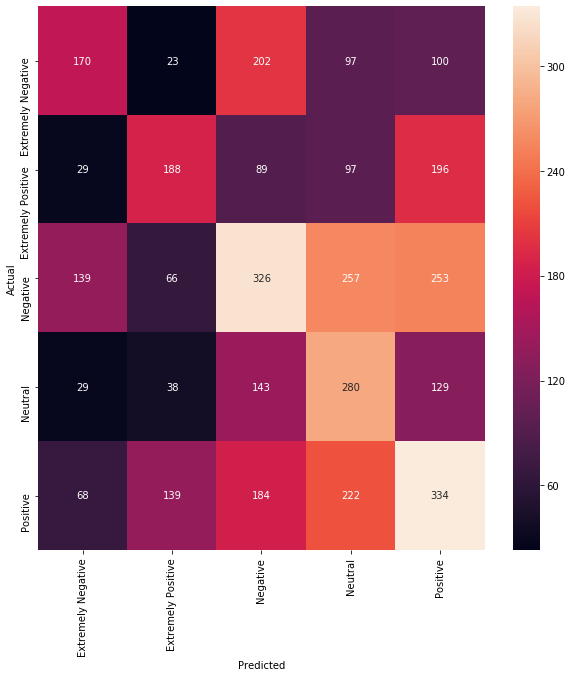

In [32]:
# generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels.keys(), yticklabels=labels.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

We have seen that with a basic Linear SVM we get an accuracy of 0.3418, we have set this accuracy with `n-grams` of two and three word combinations. 

## Trying with 1-3 word grams in the tf-idf vectorization

In [33]:
# making tf-idf vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')

X_train = tfidf.fit_transform(train_text).toarray() #vectorizing training data
X_test = tfidf.transform(test_text).toarray()       #vectorizing testing data

# fitting the model

svm_model = LinearSVC(C=1)
svm_model.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [34]:
svm_model.score(X_test, y_test)

0.5208004212743549

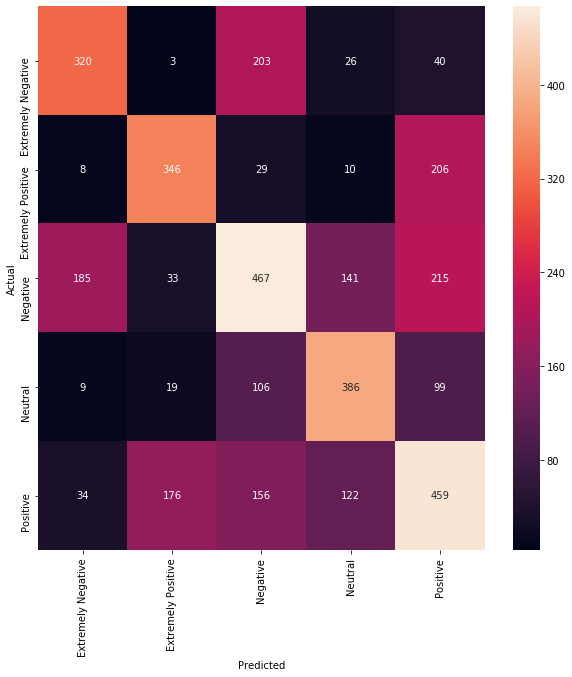

In [35]:
# predicted values
y_pred = svm_model.predict(X_test)

# generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels.keys(), yticklabels=labels.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()